In [8]:
import pandas as pd
import matplotlib.pyplot as plt


## Over Allocation

When a list of size `n` is being `append`ed to, a new list will be created that is not only big enough to hold the original plus the new element, but also some extra space. This extra space is to avoid having to reallocate the list every time a new element is added.

The allocation equation from the [CPython source code](https://github.com/python/cpython/blob/ffd9753/Objects/listobject.c#L52-L65) is as follows:

```c
new_allocated = (size_t)newsize + (newsize >> 3) + (newsize < 9 ? 3 : 6);
if (new_allocated > (size_t)PY_SSIZE_T_MAX / sizeof(PyObject *)) {
    PyErr_NoMemory();
    return -1;
}
```

The new allocation size, `new_allocated`, is determined based on the desired `newsize` of the list plus some additional space to allow for growth without immediate re-allocation. 

* `newsize`: This is the desired new size of the list, reflecting how many elements it should ideally hold after resizing.

* `newsize >> 3`: This operation performs a bitwise shift to the right by `3` bits, which is equivalent to dividing `newsize` by `8`. Adding this fraction (about 12.5% of newsize) provides a mild over-allocation proportional to the list's new size. This over-allocation is designed to balance memory usage with the need to minimize costly memory reallocations that would occur if the list grows again soon.

* `newsize < 9 ? 3 : 6`: This is a conditional operation that adds a small constant to the allocation. If the `newsize` is smaller than `9`, it adds `3`; otherwise, it adds `6`. This helps in handling very small lists efficiently, where proportional allocation might not be sufficient or optimal.

### Bitwise Shift

Binary representation (base-2) is a positional numeral system where each digit position represents a power of two, with the rightmost position as $2^0$, increasing leftward. A number $x$ in binary is computed by summing the products of each binary digit $b$ with its corresponding power of $2$. Thus, for binary digits $b_1, b_2, \ldots, b_n$, the decimal equivalent is calculated as:

$$
x = b_1 \times 2^0 + b_2 \times 2^1 + \ldots + b_n \times 2^{n-1}
$$

This binary system simplifies data processing in digital systems by using only two symbols (0 and 1).

<center>

| Binary | Decimal Expansion | Decimal Value |
|--------|-------------------|---------------|
| 1      | $1 \times 2^0$           | 1             |
| 10     | $1 \times 2^1 + 0 \times 2^0$ | 2             |
| 11     | $1 \times 2^1 + 1 \times 2^0$ | 3             |
| 100    | $1 \times 2^2 + 0 \times 2^1 + 0 \times 2^0$ | 4   |
| 101    | $1 \times 2^2 + 0 \times 2^1 + 1 \times 2^0$ | 5   |
| 110    | $1 \times 2^2 + 1 \times 2^1 + 0 \times 2^0$ | 6   |
| 111    | $1 \times 2^2 + 1 \times 2^1 + 1 \times 2^0$ | 7   |
| 1000   | $1 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 0 \times 2^0$ | 8 |
| 1001   | $1 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 1 \times 2^0$ | 9 |
| 1010   | $1 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 0 \times 2^0$ | 10 |
| 1011   | $1 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 1 \times 2^0$ | 11 |
| 1100   | $1 \times 2^3 + 1 \times 2^2 + 0 \times 2^1 + 0 \times 2^0$ | 12 |
| 1101   | $1 \times 2^3 + 1 \times 2^2 + 0 \times 2^1 + 1 \times 2^0$ | 13 |
| 1110   | $1 \times 2^3 + 1 \times 2^2 + 1 \times 2^1 + 0 \times 2^0$ | 14 |
| 1111   | $1 \times 2^3 + 1 \times 2^2 + 1 \times 2^1 + 1 \times 2^0$ | 15 |
| 10000  | $1 \times 2^4 + 0 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 0 \times 2^0$ | 16 |
| 10001  | $1 \times 2^4 + 0 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 1 \times 2^0$ | 17 |
| 10010  | $1 \times 2^4 + 0 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 0 \times 2^0$ | 18 |
| 10011  | $1 \times 2^4 + 0 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 1 \times 2^0$ | 19 |
| 10100  | $1 \times 2^4 + 0 \times 2^3 + 1 \times 2^2 + 0 \times 2^1 + 0 \times 2^0$ | 20 |

</center>

### Bitwise Right Shift by 3

Explanation from the following post: [Why does bitshifting to the right work as division?](https://math.stackexchange.com/questions/4310093/why-does-bitshifting-to-the-right-work-as-division)

Let a number $x$ have the binary representation:
$$
x = \cdots b_8 b_4 b_2 b_1
$$
where $b_1, b_2, \ldots$ are the binary digits in $\{0,1\}$. The base-10 equivalent of $x$ is computed by multiplying corresponding binary digits with their power of 2 values, as shown in the table:

<center>

| $\cdots$ | $b_8$ | $b_4$ | $b_2$ | $b_1$ |
| -------- | ----- | ----- | ----- | ----- |
| $\cdots$ | 8     | 4     | 2     | 1     |

</center>

Thus, $x$ can be written as:

\begin{align*}
x &= \cdots + 2^3 b_8 + 2^2 b_4 + 2^1 b_2 + 2^0 b_1 \\
  &= \cdots + 8b_8 + 4b_4 + 2b_2 + 1b_1
\end{align*}

Bit-shifting $x$ to the right by 3 places (denoted $x >> 3$) shifts each binary digit three places to the right, effectively dividing the value of each power of 2 by $2^3 = 8$. The table after shifting would look like:

<center>

| $\cdots$ | $b_{64}$ | $b_{32}$ | $b_{16}$ | $b_8$ |
| -------- | -------- | -------- | -------- | ----- |
| $\cdots$ | 8        | 4        | 2        | 1     |

</center>

Thus, after shifting:

\begin{align*}
x >> 3 &= \cdots + 2^3 b_{64} + 2^2 b_{32} + 2^1 b_{16} + 2^0 b_8 \\
       &= \cdots + 8b_{64} + 4b_{32} + 2b_{16} + 1b_8
\end{align*}

More generally, the operation $x >> k$ for any integer $k$ maps each term as:
$$
2^n b_n \mapsto \frac{2^n b_n}{2^k}
$$
where $n$ is the original exponent of 2 associated with each binary digit $b_n$.


In [12]:
def binary_to_decimal(binary_string):
    decimal_value = 0
    for index, digit in enumerate(reversed(binary_string)):
        decimal_value += int(digit) * (2 ** index)
    return decimal_value

binary_numbers = [format(i, 'b') for i in range(16)]  # Format integers 0 to 15 as binary

pd.DataFrame({
    'Binary': binary_numbers,
    'Decimal': [binary_to_decimal(b) for b in binary_numbers]
})


,Binary,Decimal
0,0,0
1,1,1
2,10,2
3,11,3
4,100,4
5,101,5
6,110,6
7,111,7
8,1000,8
9,1001,9


## Growth Pattern of Over Allocation

In [1]:
def calculate_growth(n):
    return n + (n >> 3) + (3 if n < 9 else 6)    

# Generate the data
data = {'n': [], 'allocated': []}
for n in range(10001):
    allocated = calculate_growth(n)
    data['n'].append(n)
    data['allocated'].append(allocated)

allocation_data = pd.DataFrame(data)

allocation_data


,n,allocated
0,0,3
1,1,4
2,2,5
3,3,6
4,4,7
...,...,...
9996,9996,11251
9997,9997,11252
9998,9998,11253
9999,9999,11254


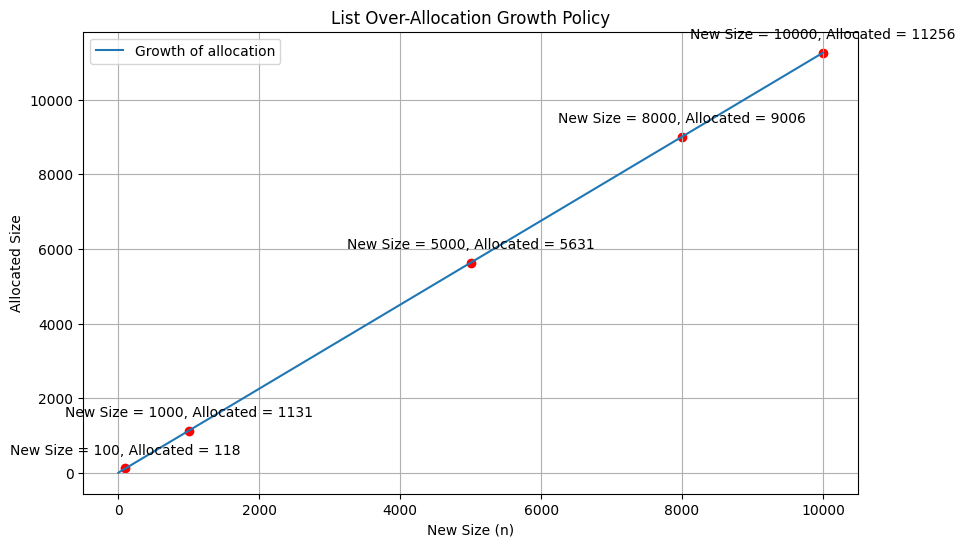

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(allocation_data['n'], allocation_data['allocated'], label='Growth of allocation')
plt.title('List Over-Allocation Growth Policy')
plt.xlabel('New Size (n)')
plt.ylabel('Allocated Size')
plt.grid(True)

points_to_annotate = [100, 1000, 5000, 8000, 10000]

for point in points_to_annotate:
    allocated_size = allocation_data.loc[allocation_data['n'] == point, 'allocated'].values[0]
    plt.scatter(point, allocated_size, color='red')
    annotation_text = f'New Size = {point}, Allocated = {data["allocated"][point]}'
    plt.annotate(
        annotation_text,
        (point, data['allocated'][point]), 
        textcoords="offset points",  
        xytext=(0,10), 
        ha='center'
    )  

plt.legend()
plt.show();
